# Introduction to Amazon Bedrock and the concept of embeddings

> *PLEASE NOTE: This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio. Also, you should have provisioned access in your AWS account for the required Bedrock models as described [here](https://catalog.us-east-1.prod.workshops.aws/event/dashboard/en-US/workshop/20-introduction/21-bedrock).*

---

In this notebook, we will set up the [`boto3` Python SDK](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to work with [Amazon Bedrock](https://aws.amazon.com/bedrock/) Foundation Models as well as install extra dependencies needed for this workshop. Specifically, we will be using the following libraries throughout the workshop...

* [LangChain](https://python.langchain.com/docs/get_started/introduction) for large language model (LLM) utilities
* [FAISS](https://github.com/facebookresearch/faiss) for vector similarity searching
* [Streamlit](https://streamlit.io/) for user interface (UI) building





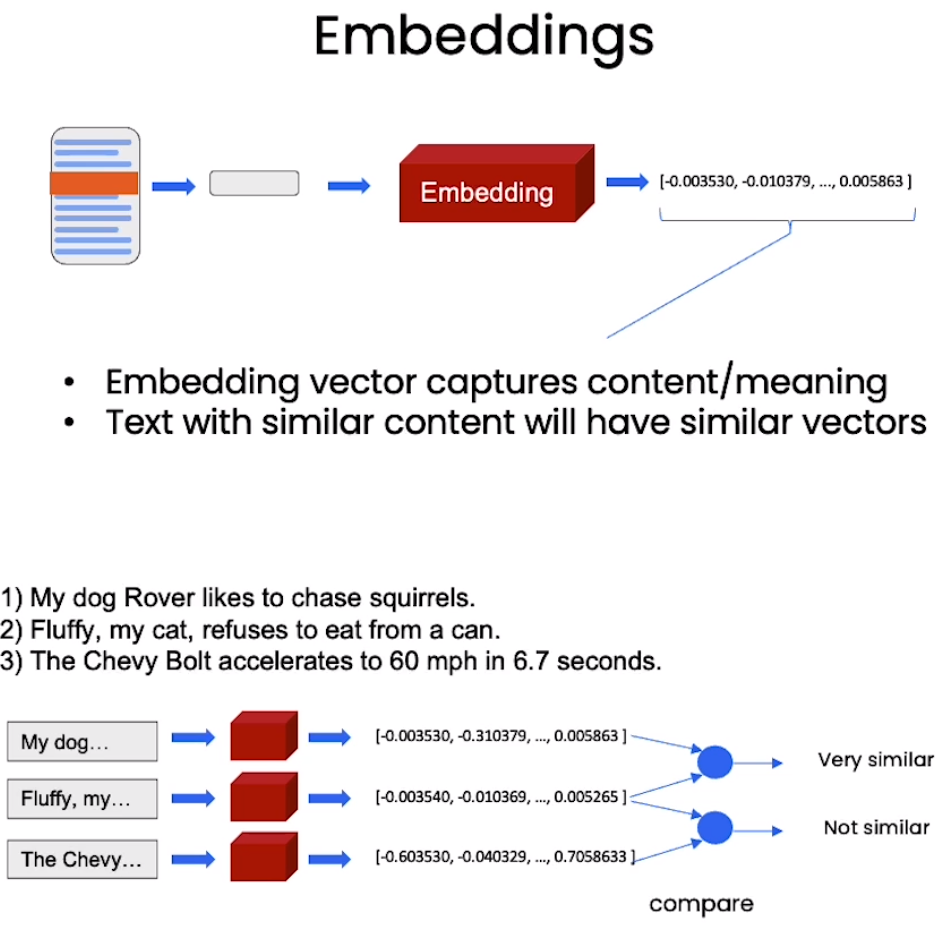
---

## Setup

In [2]:
import sys
import os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))
from utils.environment_validation import validate_environment, validate_model_access
validate_environment()

Validating base environment
Base environment validated successfully


Validating lab environment from requirements.txt ✨

ENVIRONMENT STATUS
✅  langchain==0.1.14 is installed
✅  langchain-aws is installed
✅  faiss-cpu>=1.7,<2 is installed
✅  xmltodict==0.13.0 is installed
✅  pypdf>=3.8,<4 is installed
✅  tiktoken is installed
❌ pillow==9.4.0 is not installed
❌ streamlit==1.27.0 is not installed
❌ streamlit-chat==0.1.1 is not installed
❌ unstructured==0.10.16 is not installed
❌ sqlalchemy==2.0.21 is not installed
❌ opensearch-py==2.3.1 is not installed

Installing missing libraries

pillow==9.4.0 has been installed successfully.
streamlit==1.27.0 has been installed successfully.
streamlit-chat==0.1.1 has been installed successfully.
unstructured==0.10.16 has been installed successfully.
sqlalchemy==2.0.21 has been installed successfully.
opensearch-py==2.3.1 has been installed successfully.


All required libraries are installed.🎉
You may proceed with the lab! 🚀

In [3]:
required_models = [
    "amazon.titan-embed-text-v1",
    "anthropic.claude-3-sonnet-20240229-v1:0",
    "anthropic.claude-3-haiku-20240307-v1:0",
]
validate_model_access(required_models)

MODEL ACCESS STATUS
✅  amazon.titan-embed-text-v1 is accessible
✅  anthropic.claude-3-sonnet-20240229-v1:0 is accessible
✅  anthropic.claude-3-haiku-20240307-v1:0 is accessible

All required models are accessible.🎉
You may proceed with the lab! 🚀

---
## Create the `boto3` client connection to Amazon Bedrock

Interaction with the Bedrock API is done via the AWS SDK for Python: [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

As you are running this notebook from [Amazon Sagemaker Studio](https://aws.amazon.com/sagemaker/studio/) and your Sagemaker Studio [execution role](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) has permissions to access Bedrock you can just run the cells below as-is in order to create a connection to Amazon Bedrock. This is also the case if you are running these notebooks from a computer whose default AWS credentials have access to Bedrock.

In [4]:
import json
import numpy as np

import boto3
import botocore
from IPython.display import Markdown, display
from rich import print as rprint

from utils import bedrock, print_ww


bedrock_service = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
    runtime=False
)

bedrock_runtime = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
    runtime=True
)

Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock(https://bedrock.us-east-1.amazonaws.com)
Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


Note the usage of argument `runtime=False` in the above code block. The default value of this parameter is `True`, which creates a Bedrock runtime client to perform data plane operations like invoking a model for inference. When the value of this attribute is `False`, like in this case, it creates a Bedrock client for the control plane operations, like listing the available foundation models and their versions on Bedrock.

#### Validate the connection

We can check if the client works by trying out the `list_foundation_models()` method, which will list all the models available for us to use.

## Generate embeddings

Embedding models convert text into vector representations that can then be utilized for a number of downstream usecases such as information retrieval, topic modelling, and classification.

Bedrock currently offers a number of embedding models including Amazon Titan and Cohere Embed.

Similar to the text generation model, we use the `InvokeModel` API to generate embeddings.

Titan Text embedding model (`amazon.titan-embed-text-v1`) supports an input text size of up to 8192 tokens and generates and output vector of 1536 dimensions.
It has the following input and output format:

#### Titan Embed Input

```json
{
    "inputText": "<text>"
}
```

#### Titan Embed

```json
{
    "embedding": []
}
```

The Cohere Embed options include the English only model (`cohere.embed-english-v3`) and the multilingual model (`cohere.embed-multilingual-v3`). Both models support a max input size of 512 tokens and output a vector of 1024 dimensions.
The payload body format is different from the Titan models and notably requires specifying the input type parameter for the given task being performed such as embedding of documents for retrieval, embedding of search queries, or embedding of text for classification. For more information, refer to the Cohere Embed documentation [here](https://docs.cohere.com/reference/embed).

#### Cohere Embed Input

```json
{
    "texts":["Hello world","This is a test"],
    "input_type":"search_document | search_query | classification | clustering" 
}
```


Let's see how to generate embeddings of some text:

In [6]:
prompt_data = "Amazon Bedrock supports foundation models from industry-leading providers such as \
AI21 Labs, Anthropic, Stability AI, and Amazon. Choose the model that is best suited to achieving \
your unique goals."

In [7]:
body = json.dumps({"inputText": prompt_data})
modelId = "amazon.titan-embed-text-v1"
accept = "application/json"
contentType = "application/json"

response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

embedding = response_body.get("embedding")
rprint(f"The embedding vector has {len(embedding)} values\n{embedding[0:3]+['...']+embedding[-3:]}")

The embedding vector has 1536 values
[0.16601562, 0.23632812, 0.703125, '...', 0.26953125, -0.609375, -0.55078125]

## Semantic Similarity with Amazon Titan Embeddings

Semantic search refers to searching for information based on the meaning and concepts of words and phrases, rather than just matching keywords. Embedding models like Amazon Titan Embeddings allow semantic search by representing words and sentences as dense vectors that encode their semantic meaning.

Semantic matching is extremely helpful for RAG because it returns results that are conceptually related to the user's query, even if they don't contain the exact keywords. This leads to more relevant and useful search results which can be injected into our LLM's prompts.

First, let's take a look below to illustrate the capabilities of semantic search with Amazon Titan.

The `embed_text_input` function below is an example function which will return an embedding output based on text output.

In [8]:
def embed_text_input(bedrock_client, prompt_data, modelId="amazon.titan-embed-text-v1"):
    accept = "application/json"
    contentType = "application/json"
    body = json.dumps({"inputText": prompt_data})
    response = bedrock_client.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())
    embedding = response_body.get("embedding")
    return np.array(embedding)

To give an example of how this works, let's take a look at matching a user input to two "documents". We use a dot product calculation to rank the similarity between the input and each document, but there are many ways to do this in practice.

In [9]:
# commonly used distance metric for comparing the similarity of two vectors. It is the cosine of the angle between two vectors in a multi-dimensional space.
def cosine_similarity(a, b):

    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [10]:
user_input = 'Things to do on vacation'
document_1 = 'swimming, site seeing, sky diving'
document_2 = 'cleaning, note taking, studying'

user_input_vector = embed_text_input(bedrock_runtime, user_input)
document_1_vector = embed_text_input(bedrock_runtime, document_1)
document_2_vector = embed_text_input(bedrock_runtime, document_2)

doc_1_match_score = cosine_similarity(user_input_vector, document_1_vector)
doc_2_match_score = cosine_similarity(user_input_vector, document_2_vector)

print(f'"{user_input}" matches "{document_1}" with a score of {doc_1_match_score:.1f}')
print(f'"{user_input}" matches "{document_2}" with a score of {doc_2_match_score:.1f}')

"Things to do on vacation" matches "swimming, site seeing, sky diving" with a score of 0.6
"Things to do on vacation" matches "cleaning, note taking, studying" with a score of 0.4


In [11]:
user_input = 'Things to do that are productive'
document_1 = 'swimming, site seeing, sky diving'
document_2 = 'cleaning, note taking, studying'

user_input_vector = embed_text_input(bedrock_runtime, user_input)
document_1_vector = embed_text_input(bedrock_runtime, document_1)
document_2_vector = embed_text_input(bedrock_runtime, document_2)

doc_1_match_score = cosine_similarity(user_input_vector, document_1_vector)
doc_2_match_score = cosine_similarity(user_input_vector, document_2_vector)

print(f'"{user_input}" matches "{document_1}" with a score of {doc_1_match_score:.1f}')
print(f'"{user_input}" matches "{document_2}" with a score of {doc_2_match_score:.1f}')

"Things to do that are productive" matches "swimming, site seeing, sky diving" with a score of 0.3
"Things to do that are productive" matches "cleaning, note taking, studying" with a score of 0.6


The example above shows how the semantic meaning behind the user input and provided documents can be effectively ranked by Amazon Titan.

## Next steps

In this notebook we have successfully set up our Bedrock compatible environment and showed some basic examples of invoking Amazon Bedrock models using the AWS Python SDK. You're now ready to move on to the next notebook to start building our retrieval augmented generation (RAG) application!